In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_zip = '/content/drive/MyDrive/ingredients_images_rev.zip'
zip_ref = zipfile.ZipFile(file_zip, 'r')
zip_ref.extractall()
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/drive/MyDrive/ingredients_images_rev.zip' mode='r'>>

In [4]:
source_path = 'ingredients_images'

source_path_apple = os.path.join(source_path, 'apple')
source_path_banana = os.path.join(source_path, 'banana')
source_path_broccoli = os.path.join(source_path, 'broccoli')
source_path_cabbage = os.path.join(source_path, 'cabbage')
source_path_carrot = os.path.join(source_path, 'carrot')

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_apple))} images of apple.")
print(f"There are {len(os.listdir(source_path_banana))} images of banana.")
print(f"There are {len(os.listdir(source_path_broccoli))} images of broccoli.")
print(f"There are {len(os.listdir(source_path_cabbage))} images of cabbage.")
print(f"There are {len(os.listdir(source_path_carrot))} images of carrot.")

There are 100 images of apple.
There are 100 images of banana.
There are 100 images of broccoli.
There are 100 images of cabbage.
There are 100 images of carrot.


In [5]:
# Define root directory
root_dir = 'ingredients_dataset'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_test_dirs(root_path):

      try:
        subdirs = ['apple', 'banana', 'broccoli', 'cabbage', 'carrot']

        for subdir in subdirs:
          train_dir = os.path.join(root_path,'training')
          train_path = os.path.join(train_dir, subdir)
          os.makedirs(train_path)
          val_dir = os.path.join(root_path,'validation')
          val_path = os.path.join(val_dir, subdir)
          os.makedirs(val_path)

      except OSError:
          pass

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [6]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

ingredients_dataset/validation
ingredients_dataset/training
ingredients_dataset/validation/banana
ingredients_dataset/validation/cabbage
ingredients_dataset/validation/carrot
ingredients_dataset/validation/apple
ingredients_dataset/validation/broccoli
ingredients_dataset/training/banana
ingredients_dataset/training/cabbage
ingredients_dataset/training/carrot
ingredients_dataset/training/apple
ingredients_dataset/training/broccoli


In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    files=[]
    for filename in os.listdir(SOURCE):
      file = SOURCE + filename
      if os.path.getsize(file) > 0:
        files.append(filename)
      else:
        print(filename + " is zero length, so ignoring.")
    
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
      this_file = SOURCE + filename
      destination = TRAINING + filename
      copyfile(this_file, destination)

    for filename in testing_set:
      this_file = SOURCE + filename
      destination = TESTING + filename
      copyfile(this_file, destination)

In [8]:
dirs = ['apple', 'banana', 'broccoli', 'cabbage', 'carrot']

for dir in dirs:

  SOURCE_DIR = "ingredients_images/"+dir+"/"
  TRAINING_DIR = "ingredients_dataset/training/"
  #TESTING_DIR = "ingredients_dataset/testing/"
  VALIDATION_DIR = "ingredients_dataset/validation/"
  #temp = "ingredients_dataset/temp/"
  TRAIN_DIR = os.path.join(TRAINING_DIR, dir+"/")
  #TEST_DIR = os.path.join(TESTING_DIR, dir1+"/")
  VAL_DIR = os.path.join(VALIDATION_DIR, dir+"/")

  if len(os.listdir(TRAIN_DIR)) > 0:
    for file in os.scandir(TRAIN_DIR):
      os.remove(file.path)
  #if len(os.listdir(TEST_DIR)) > 0:
    #for file in os.scandir(TEST_DIR):
     # os.remove(file.path)
  if len(os.listdir(VAL_DIR)) > 0:
    for file in os.scandir(VAL_DIR):
      os.remove(file.path)
  #if len(os.listdir(temp)) > 0:
    #for file in os.scandir(temp):
     # os.remove(file.path)
  
  # Define proportion of images used for training
  split_size = .8

  # Messages about zero length images should be printed out
  split_data(SOURCE_DIR, TRAIN_DIR, VAL_DIR, split_size)
  #split_data(temp, TEST_DIR, VAL_DIR, 0.5)

  # Check that the number of images matches the expected output
  mess1 = "There are " + str(len(os.listdir(TRAIN_DIR))) + " images of " + dir + " for training"
  #mess2 = "There are " + str(len(os.listdir(TEST_DIR))) + " images of " + dir + " for testing"
  mess3 = "There are " + str(len(os.listdir(VAL_DIR))) + " images of " + dir + " for validation"
  print(mess1)
  print(mess3)
  #print(mess2)

There are 80 images of apple for training
There are 20 images of apple for validation
There are 80 images of banana for training
There are 20 images of banana for validation
There are 80 images of broccoli for training
There are 20 images of broccoli for validation
There are 80 images of cabbage for training
There are 20 images of cabbage for validation
There are 80 images of carrot for training
There are 20 images of carrot for validation


In [9]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale= 1.0/255.0,
                                     rotation_range= 40,
                                     width_shift_range= 0.2,
                                     height_shift_range= 0.2,
                                     shear_range= 0.2,
                                     zoom_range= 0.2,
                                     horizontal_flip= True)

  # Pass in the appropiate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory= TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale = 1./255.,
                                          rotation_range= 40,
                                          width_shift_range= 0.2,
                                          height_shift_range= 0.2,
                                          shear_range= 0.2,
                                          zoom_range= 0.2,
                                          horizontal_flip= True)

  # Pass in the appropiate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory= VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [10]:
TRAINING_DIR = "ingredients_dataset/training/"
VALIDATION_DIR = "ingredients_dataset/validation/"

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [11]:
train_generator.class_indices

{'apple': 0, 'banana': 1, 'broccoli': 2, 'cabbage': 3, 'carrot': 4}

In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
for i, layer in enumerate(pretrained_model.layers):
    print(i, layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [15]:
for layer in model.layers[:143]:
    layer.trainable = False
for layer in model.layers[143:]:
    layer.trainable = True

model.compile(optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator)

Epoch 1/30
 9/13 [===================>..........] - ETA: 4s - loss: 0.7835 - accuracy: 0.7500

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


13/13 [==============================] - 37s 2s/step - loss: 0.6287 - accuracy: 0.7975 - val_loss: 0.1276 - val_accuracy: 0.9600
Epoch 2/30
13/13 [==============================] - 21s 2s/step - loss: 0.1462 - accuracy: 0.9525 - val_loss: 0.4729 - val_accuracy: 0.9400
Epoch 3/30
13/13 [==============================] - 21s 2s/step - loss: 0.1220 - accuracy: 0.9625 - val_loss: 0.3272 - val_accuracy: 0.9500
Epoch 4/30
13/13 [==============================] - 21s 2s/step - loss: 0.0876 - accuracy: 0.9650 - val_loss: 0.4910 - val_accuracy: 0.9300
Epoch 5/30
13/13 [==============================] - 21s 2s/step - loss: 0.1071 - accuracy: 0.9700 - val_loss: 0.7449 - val_accuracy: 0.9400
Epoch 6/30
13/13 [==============================] - 22s 2s/step - loss: 0.1006 - accuracy: 0.9800 - val_loss: 0.3533 - val_accuracy: 0.9600
Epoch 7/30
13/13 [==============================] - 21s 2s/step - loss: 0.0663 - accuracy: 0.9800 - val_loss: 0.8336 - val_accuracy: 0.9500
Epoch 8/30
13/13 [=============

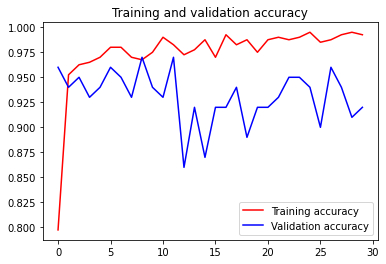

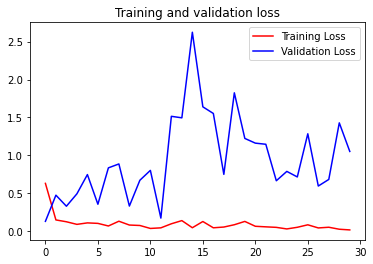

In [16]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving apple.jpg to apple.jpg
Saving banana.jpg to banana.jpg
Saving broccoli.jpg to broccoli.jpg


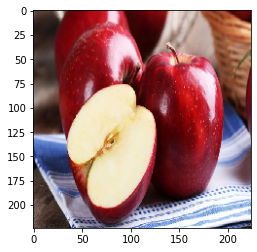

apple: 63.15%
banana: 0.13%
broccoli: 0.07%
cabbage: 36.64%
carrot: 0.00%
apple


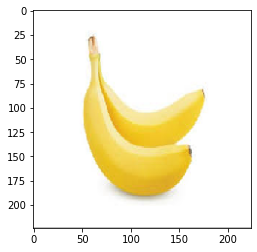

apple: 0.00%
banana: 100.00%
broccoli: 0.00%
cabbage: 0.00%
carrot: 0.00%
banana


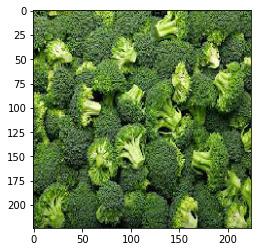

apple: 0.00%
banana: 0.00%
broccoli: 100.00%
cabbage: 0.00%
carrot: 0.00%
broccoli


In [28]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

labels = train_generator.class_indices.keys()

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  #x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  min = 0.5
  for (label, p) in zip(labels, proba):
    if p >= min:
      predict = str(label)
      min = p
    print("{}: {:.2f}%".format(label, p * 100))

  print(predict)

In [29]:
!git clone https://github.com/intancitra/healthyplate.git

Cloning into 'healthyplate'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (496/496), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 597 (delta 258), reused 379 (delta 160), pack-reused 101
Receiving objects: 100% (597/597), 5.10 MiB | 6.14 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [39]:
import csv

predict = ['Apel']
result = []
with open("./healthyplate/ML/Bahan 50.csv", 'r') as csvfile:
  csv_reader = csv.DictReader(csvfile)
  line_count = 1
  for row in csv_reader:
    for key in predict:
      if key in row["Bahan-Bahan"]:
        result.append(str(line_count))
        break
    line_count += 1

print(result)

['9', '10', '44']


In [40]:
#Remove duplicates of the result
res = set(map(int,result))
print(res)

{9, 10, 44}


In [41]:
#Show the recipe based on the result (ID)
recipe = []
with open("./healthyplate/ML/Bahan 50.csv", 'r') as csvfile:
  csv_reader = csv.reader(csvfile, delimiter=',')
  line_count = 0
  for row in csv_reader:
    if line_count in res:
      recipe.append(row[1])
    line_count += 1

print(recipe)

['Acar Sehat Madu', 'Jus Apel Sehat', 'Healthy Apple Crumble']


In [42]:
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


In [43]:
# Select mode of optimization
mode = "Storage" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [44]:
# Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [45]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2822688

In [46]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [47]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 224 224   3] <class 'numpy.float32'>

1 output(s):
[1 5] <class 'numpy.float32'>


In [48]:
saved_model_path = "./my_model.h5"

model.save(saved_model_path)